In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
import shap
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, TensorDataset

C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data loading

In [2]:
# Load Datasets from downloaded csv files
train_data_ID = pd.read_csv('data/cs-training.csv')
test_data_ID = pd.read_csv('data/cs-test.csv')

# EDA (Exploratory Data Analysis)

In [3]:
train_data_ID.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [4]:
test_data_ID.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [5]:
# Drop the 'Unnamed: 0' column from both datasets as it corresponds to client ID which is not relevant for the prediction
train_data = train_data_ID.drop('Unnamed: 0', axis=1)
test_data = test_data_ID.drop('Unnamed: 0', axis=1)

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

Understanding of our dataset :
<br>
- SeriousDlqin2yrs (Target variable): 1 if the person had a serious delinquency in the last 2 years, 0 otherwise.
- RevolvingUtilizationOfUnsecuredLines: Total balance on credit cards / Sum(credit limits percentage)
- Age: Age of the borrower.
- NumberOfTime30-59DaysPastDueNotWorse: Number of times the borrower has been 30-59 days overdue.
- DebtRatio: Monthly debt payments divided by monthly gross income.
- MonthlyIncome: Monthly income of the borrower.
- NumberOfOpenCreditLinesAndLoans: Total number of credit accounts (credit cards, loans, etc.).
- NumberOfTimes90DaysLate: Number of times the borrower has been at least 90 days overdue.
- NumberRealEstateLoansOrLines: Number of mortgage and real estate loans the borrower has.
- NumberOfTime60-89DaysPastDueNotWorse: Number of times the borrower has been 60-89 days overdue.
- NumberOfDependents: Number of dependents (e.g., children or family members financially supported).

In [7]:
train_data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


This first description showcases some anomalies in our dataset :
- Unsual Distribution :
    - RevolvingUtilizationOfUnsecuredLines : Big difference between maximum value and Q3 (75%)
    - NumberOfTime30-59DaysPastDueNotWorse : Big difference in quartile distribution
    - DebtRatio : Big difference between maximum value and Q3 (75%)
    - NumberOfTimes90DaysLate : Big difference in quartile distribution
    - NumberOfTime60-89DaysPastDueNotWorse : Big difference in quartile distribution
    - NumberOfDependents : Big difference between maximum value and Q3 (75%)

Need further analysis to draw conclusions. We need further data distribution exploration.
<br>
- Abnormal values :
    - Age : Minimum value : 0 => Drop lines where age < 18 (you cannot have a credit before 18).

In [8]:
# Check for missing values in train dataset
train_data.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [9]:
# Check for missing values in test dataset
test_data.isnull().sum()

SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                            20103
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                        2626
dtype: int64

For both training and test datasets the columns 'MonthlyIncome' and 'NumberOfDependents' contain Null values.
<br>Thus we will replace them coherently

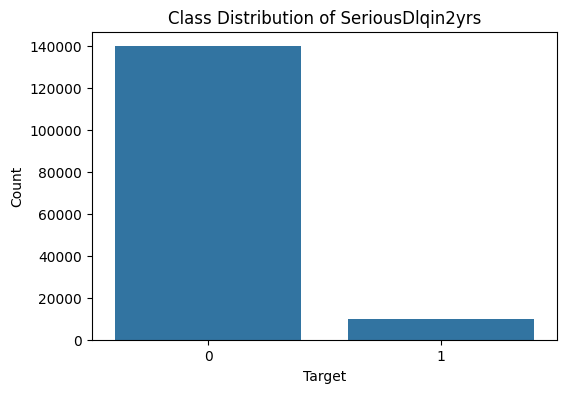

In [10]:
# Target Distribution ('SeriousDlqin2yrs')
target_counts = train_data['SeriousDlqin2yrs'].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values)
plt.title("Class Distribution of SeriousDlqin2yrs")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

<br>The target distribution is very imbalanced, thus we cannot use classic evaluation metrics to evaluate the precision of our model.
<br>We will see further what metric to choose to evaluate our model's performance.

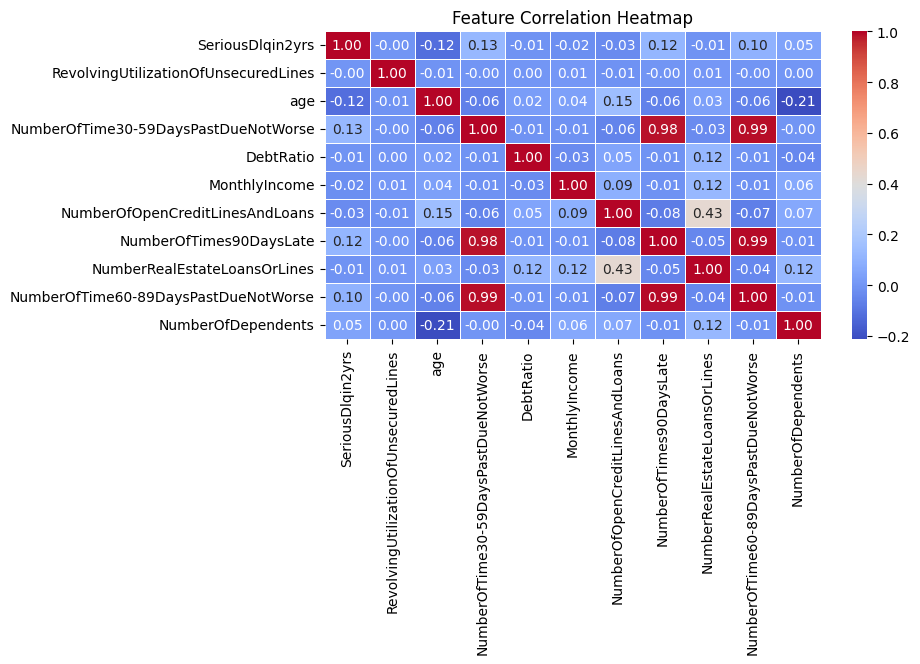

In [11]:
# Correlation heatmap of the features
plt.figure(figsize=(8, 4))
corr_matrix = train_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

We can see a strong correlation between the features : 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse' and 'NumberOfTimes90DaysLate'. Even though it is not very surprising, a correlation of almost 1 seems too high.
<br><br>We need to make further analysis to understand the reason behind these very high correlations.

Moreover, we do not see particularely strong correlation between our features and the target 'SeriousDlqin2yrs'. We can conclude that a simple linear approach is not suitable.

## Feature Engineering

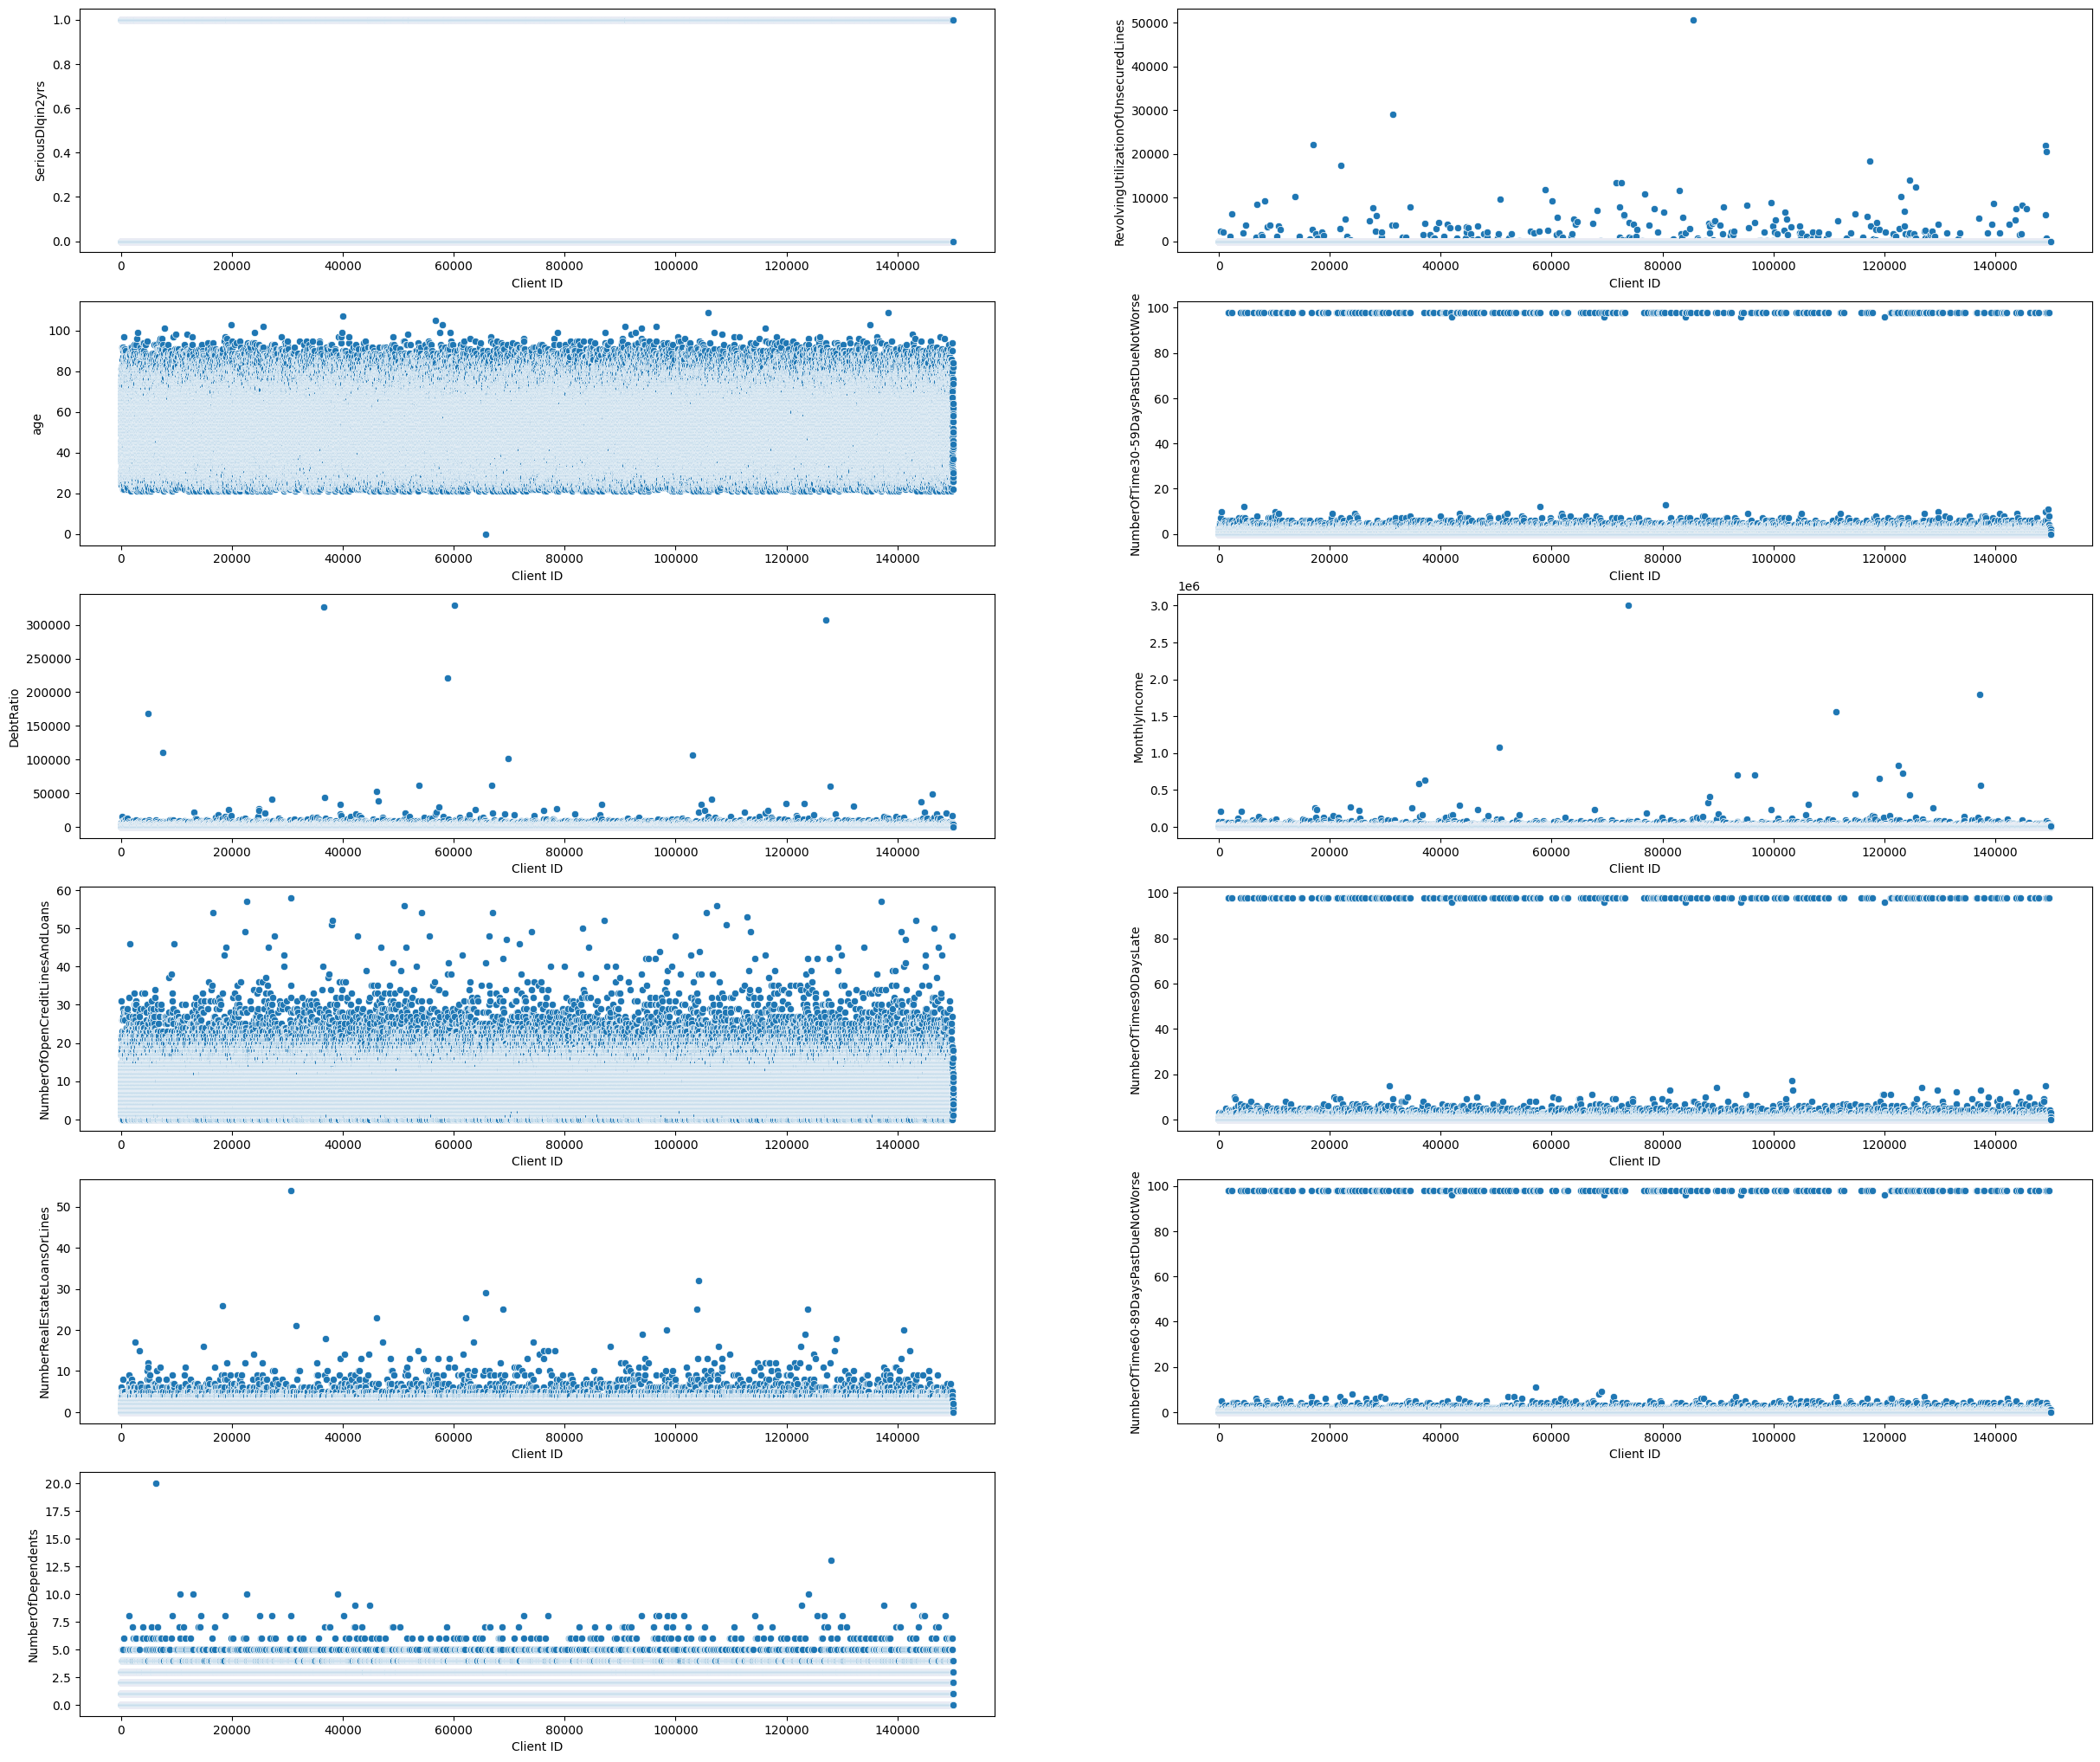

In [12]:
# Scatter plot of each feature to check for outliers
fig = plt.figure(figsize=(30, 30))
for i, feature in enumerate(train_data.columns):
    axes = fig.add_subplot(7, 2, i+1)
    sns.scatterplot(x=train_data_ID['Unnamed: 0'], y=train_data[feature], ax=axes)
    axes.set_xlabel('Client ID')
plt.show()

The scatterplots shows that the features 'NumberOfTime30-59DaysPastDueNotWorse' , 'NumberOfTime60-89DaysPastDueNotWorse' and 'NumberOfTimes90DaysLate' have similar distributions divided in two distinguished clusters [0, 20] and [90, 100].
<br>Intuitively, 90+ values seem unsual as most lenders would cut off access much earlier that 90+ days late in payements.
<br>Moreover it seems not normal that there is such a big gap between the two clusters with no values in between.

Thus we will cap these values (replace them by the maximum value that is inferior to 90).

The scatter graph also helps us vizualizing each feature's distribution.
<br><br>
- Other features present outliers :
    - 'MonthlyIncome': Explainable => huge monthly income
    - 'NumberOfDependents': Explainable => customer with many dependents
    - 'RevolvingUtilizationOfUnsecuredLines': presence of surprisingly very high values
    - 'DebtRatio': presence of surprisingly very high values
    - 'NumberOfOpenCreditLinesAndLoans' : Seems to have some outliers

<br>Need a more detailed analysis of feature distribution for 'DebtRatio', 'RevolvingUtilizationOfUnsecuredLines' and 'NumberOfOpenCreditLinesAndLoans'

<Figure size 3000x3000 with 0 Axes>

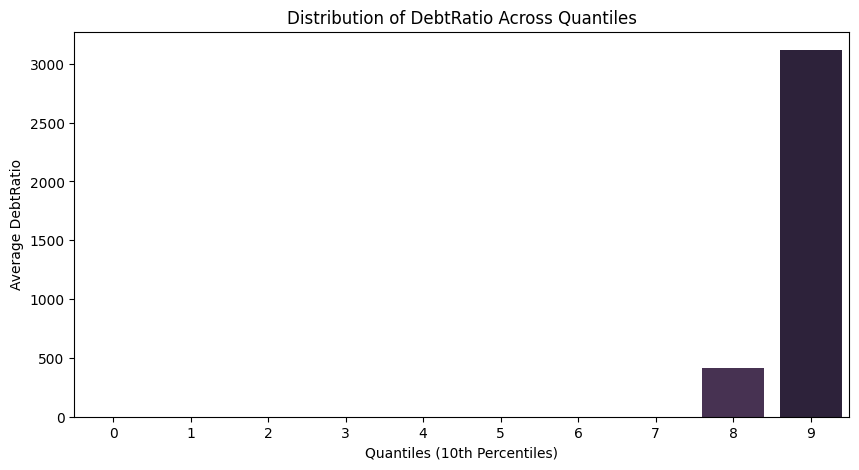

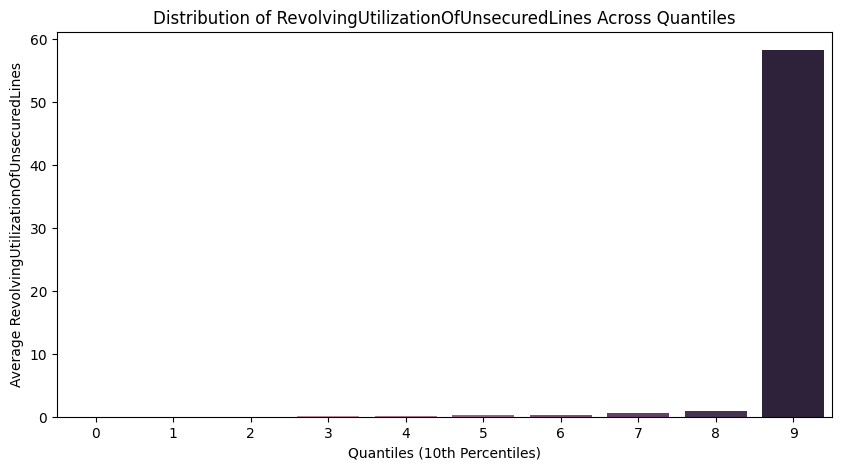

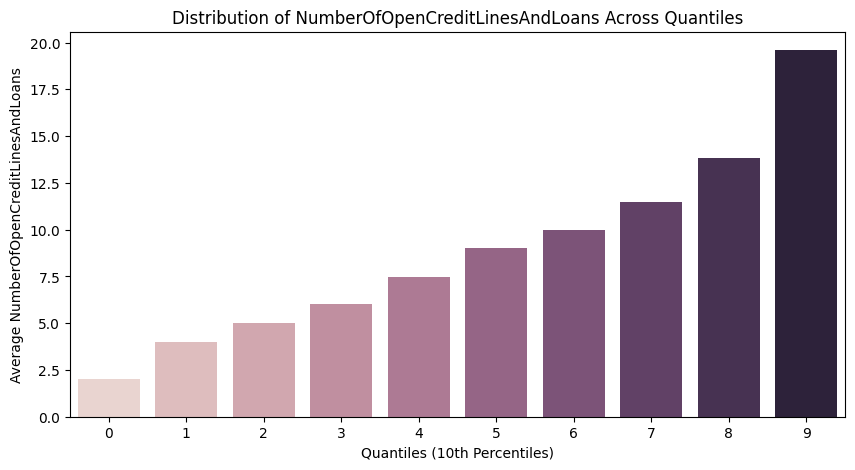

In [13]:
detailed_features = ['DebtRatio', 'RevolvingUtilizationOfUnsecuredLines', 'NumberOfOpenCreditLinesAndLoans']

fig = plt.figure(figsize=(30, 30))
# 10th Quantile Distribution of Detailed Features
for feature in detailed_features:
    train_data['quantile'] = pd.qcut(train_data[feature], q=10, labels=False, duplicates='drop')
    quantile_means = train_data.groupby('quantile')[feature].mean()
    plt.figure(figsize=(10, 5))
    sns.barplot(x=quantile_means.index, y=quantile_means.values, hue=quantile_means.index, legend=False),
    plt.xlabel("Quantiles (10th Percentiles)")
    plt.ylabel(f"Average {feature}")
    plt.title(f"Distribution of {feature} Across Quantiles")
    plt.show()
    train_data.drop(columns=['quantile'], inplace=True)

- 'NumberOfOpenCreditLinesAndLoans': looks normal.
- 'DebtRatio': Big disproportion between high and low values peak on the 8th quantile
- 'RevolvingUtilizationOfUnsecuredLines': Big disproportion between high and low values peak on the 9th quantile

Let's take a closer look at those upper quantiles.

#### 'DebtRatio' Detailed Analysis

In [14]:
# Detailed Analysis of the 80th Percentile of 'DebtRatio'
debt_ratio_80th = train_data[train_data["DebtRatio"] >= train_data["DebtRatio"].quantile(0.80)]
debt_ratio_80th.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,30065.000000,30065.000000,30065.000000,30065.000000,30065.000000,2476.000000,30065.000000,30065.000000,30065.000000,30065.000000,26711.000000
mean,0.055147,6.824756,55.510294,0.286014,1759.780883,378.918821,7.610943,0.176518,0.943057,0.148013,0.376961
std,0.228271,219.363035,15.006384,3.047508,4271.297935,1784.447565,4.829849,3.023976,1.095046,3.004018,0.881342
min,0.000000,0.000000,21.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.020796,45.000000,0.000000,263.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.089390,56.000000,0.000000,1262.000000,0.000000,7.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.424725,66.000000,0.000000,2446.000000,1.000000,10.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,22198.000000,109.000000,98.000000,329664.000000,33333.000000,58.000000,98.000000,54.000000,98.000000,10.000000


We can see that there are a lot of 'MonthlyIncome' values missing, and 75% of the 'MonthlyIncome' values are 0 or 1, which looks like error in our data. 
<br>Let's take a closer look at those.

In [15]:
# Detailed Analysis of 'MonthlyIncome' values of 0 and 1 in the 80th Percentile of 'DebtRatio'
debt_ratio_80th[(debt_ratio_80th['MonthlyIncome'] == 0) | (debt_ratio_80th['MonthlyIncome'] == 1)].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000
mean,0.035523,3.468856,48.656448,0.180535,1532.690024,0.265207,7.648662,0.057421,0.809246,0.048662,0.839416
std,0.185143,130.742371,15.394954,0.570289,2870.420298,0.441551,4.771320,0.422830,0.918602,0.344051,1.221961
min,0.000000,0.000000,21.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.026275,37.000000,0.000000,227.500000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.118547,47.000000,0.000000,960.000000,0.000000,7.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.454128,61.000000,0.000000,1972.000000,1.000000,10.000000,0.000000,1.000000,0.000000,2.000000
max,1.000000,5893.000000,103.000000,6.000000,61106.500000,1.000000,31.000000,11.000000,9.000000,9.000000,10.000000


As 0 and 1 are not usual values for 'MonthlyIncome', we can suspect that it is a data entry errors.
<br>Let's check how many lines have the same values for 'MonthlyIncome' and 'SeriousDlqin2yrs'.

In [16]:
# Detailed Analysis of 'MonthlyIncome' equal to 'SeriousDlqin2yrs' in the 80th Percentile of 'DebtRatio'
debt_ratio_80th[(debt_ratio_80th['MonthlyIncome'] == debt_ratio_80th['SeriousDlqin2yrs'])].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000
mean,0.009556,4.737850,49.296928,0.161092,1670.921160,0.009556,7.526280,0.035495,0.769966,0.034130,0.778157
std,0.097321,154.844133,16.044462,0.543203,2854.486299,0.097321,4.736589,0.298166,0.891474,0.302871,1.209847
min,0.000000,0.000000,21.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.022166,37.000000,0.000000,217.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.107684,48.000000,0.000000,1062.000000,0.000000,7.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.422975,62.000000,0.000000,2253.000000,0.000000,10.000000,0.000000,1.000000,0.000000,2.000000
max,1.000000,5893.000000,94.000000,6.000000,60212.000000,1.000000,31.000000,6.000000,7.000000,9.000000,10.000000


We realize that 1465/2055 values have the same values for 'MonthlyIncome' and 'SeriousDlqin2yrs' so we will consider these values as data entry errors as the create a lot of variance and will add bias to our predictions.
<br>Thus, we will remove these values.

#### 'RevolvingUtilizationOfUnsecuredLines' Detailed Analysis

In [17]:
# Detailed Analysis of the 90th Percentile of 'RevolvingUtilizationOfUnsecuredLines'
unsecured_lines_90th = train_data[train_data["RevolvingUtilizationOfUnsecuredLines"] >= train_data["RevolvingUtilizationOfUnsecuredLines"].quantile(0.9)]
unsecured_lines_90th.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,11484.000000,15000.000000,15000.000000,15000.000000,15000.0000,14488.000000
mean,0.231667,58.291581,45.042733,2.258733,254.413424,4821.263410,3.967933,2.203333,0.567133,1.9710,0.773192
std,0.421911,787.896798,14.573227,12.972898,1124.912584,5465.243822,3.609179,12.984371,0.904773,12.9858,1.142039
min,0.000000,0.981279,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
25%,0.000000,1.000000,33.000000,0.000000,0.081218,2353.500000,1.000000,0.000000,0.000000,0.0000,0.000000
50%,0.000000,1.000000,44.000000,0.000000,0.288875,3750.000000,3.000000,0.000000,0.000000,0.0000,0.000000
75%,0.000000,1.000000,55.000000,1.000000,0.827439,5850.000000,6.000000,1.000000,1.000000,0.0000,1.000000
max,1.000000,50708.000000,103.000000,98.000000,61907.000000,251608.000000,42.000000,98.000000,25.000000,98.0000,13.000000


We can still see a big difference between the Q3 and the max value.
<br>Let's take a closer look to the values.

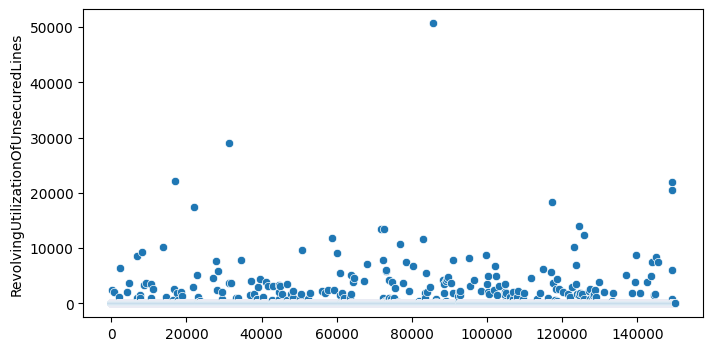

In [18]:
fig = plt.figure(figsize=(8, 4))
# Detailed Analysis of 'RevolvingUtilizationOfUnsecuredLines' 90th Percentile
sns.scatterplot(unsecured_lines_90th['RevolvingUtilizationOfUnsecuredLines'])
plt.show()

It is suprinsing to have this much data that are very high as 'RevolvingUtilizationOfUnsecuredLines' is a ratio: 
<br>Total balance on credit cards / Sum(Credit limit percentage).
<br>Acceptable values should be between [0, 1]; even though values > 1 are also possible but should be very rare cases.
<br>The most surprising part is that we see values that are surprisingly big.
<br>We will take a look at values that are > 2 (which is already an impressively high value) and see if they have any impact on our prediction.

(371, 11)


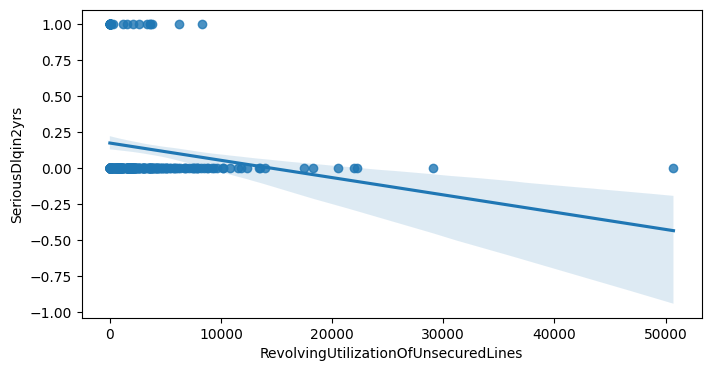

In [19]:
fig = plt.figure(figsize=(8, 4))
unsecured_lines_90th_2 = unsecured_lines_90th[unsecured_lines_90th['RevolvingUtilizationOfUnsecuredLines'] > 2]
print(unsecured_lines_90th_2.shape)
# Detailed Analysis of 'NumberOfOpenCreditLinesAndLoans' in the 90th Percentile of 'RevolvingUtilizationOfUnsecuredLines'
sns.regplot(x=unsecured_lines_90th_2['RevolvingUtilizationOfUnsecuredLines'], y=unsecured_lines_90th_2['SeriousDlqin2yrs'])
plt.show()

The regplot graph indicates that these values can have huge impact on our predictions. 
<br>Thus, we will consider them as data entry errors.

## Data Pre-Processing

### Data Cleaning

Cleaning data considering upper analysis conclusions

In [20]:
# Create copies of datasets for data cleaning
train_data_cleaned = train_data.copy()
test_data_cleaned = test_data.copy()

In [21]:
# Replace null values in 'MonthlyIncome' and 'NumberOfDependents'

# 'MonthlyIncome' is replaced by the median value as it is a continuous variable
train_data_cleaned.fillna({'MonthlyIncome': train_data_cleaned['MonthlyIncome'].median()}, inplace=True)
test_data_cleaned.fillna({'MonthlyIncome': test_data_cleaned['MonthlyIncome'].median()}, inplace=True)

# 'NumberOfDependents' is replaced by 0, we assume that the null values correspond to clients with no dependents
train_data_cleaned.fillna({'NumberOfDependents': 0}, inplace=True)
test_data_cleaned.fillna({'NumberOfDependents': 0}, inplace=True)

In [22]:
# Drop lines where 'age' is less than 18 as it is not possible to have a client with less than 18 years old
train_data_cleaned = train_data_cleaned[train_data_cleaned['age'] >= 18]
test_data_cleaned = test_data_cleaned[test_data_cleaned['age'] >= 18]

In [23]:
# Cap the outliers in 'NumberOfTime30-59DaysPastDueNotWorse' , 'NumberOfTime60-89DaysPastDueNotWorse' and 'NumberOfTimes90DaysLate'

# Set cap values
cap_3059_train = max(np.unique(train_data_cleaned[train_data_cleaned['NumberOfTime30-59DaysPastDueNotWorse']<90]['NumberOfTime30-59DaysPastDueNotWorse']))
cap_6089_train = max(np.unique(train_data_cleaned[train_data_cleaned['NumberOfTime60-89DaysPastDueNotWorse']<90]['NumberOfTime60-89DaysPastDueNotWorse']))
cap_90_train = max(np.unique(train_data_cleaned[train_data_cleaned['NumberOfTimes90DaysLate']<90]['NumberOfTimes90DaysLate']))

# Cap the outliers using the cap values
train_data_cleaned['NumberOfTime30-59DaysPastDueNotWorse'] = train_data_cleaned['NumberOfTime30-59DaysPastDueNotWorse'].apply(lambda x: cap_3059_train if x >= 90 else x)
train_data_cleaned['NumberOfTime60-89DaysPastDueNotWorse'] = train_data_cleaned['NumberOfTime60-89DaysPastDueNotWorse'].apply(lambda x: cap_6089_train if x >= 90 else x)
train_data_cleaned['NumberOfTimes90DaysLate'] = train_data_cleaned['NumberOfTimes90DaysLate'].apply(lambda x: cap_90_train if x >= 90 else x)

# Same for test dataset

# Set cap values
cap_3059_test = max(np.unique(test_data_cleaned[test_data_cleaned['NumberOfTime30-59DaysPastDueNotWorse']<90]['NumberOfTime30-59DaysPastDueNotWorse']))
cap_6089_test = max(np.unique(test_data_cleaned[test_data_cleaned['NumberOfTime60-89DaysPastDueNotWorse']<90]['NumberOfTime60-89DaysPastDueNotWorse']))
cap_90_test = max(np.unique(test_data_cleaned[test_data_cleaned['NumberOfTimes90DaysLate']<90]['NumberOfTimes90DaysLate']))

# Cap the outliers using the cap values
test_data_cleaned['NumberOfTime30-59DaysPastDueNotWorse'] = test_data_cleaned['NumberOfTime30-59DaysPastDueNotWorse'].apply(lambda x: cap_3059_test if x >= 90 else x)
test_data_cleaned['NumberOfTime60-89DaysPastDueNotWorse'] = test_data_cleaned['NumberOfTime60-89DaysPastDueNotWorse'].apply(lambda x: cap_6089_test if x >= 90 else x)
test_data_cleaned['NumberOfTimes90DaysLate'] = test_data_cleaned['NumberOfTimes90DaysLate'].apply(lambda x: cap_90_test if x >= 90 else x)

In [24]:
# Removing rows where 'DebpRatio' in the 80th percentile and 'MonthlyIncome' is equal to 'SeriousDlqin2yrs'
train_data_cleaned.drop(train_data_cleaned[(train_data_cleaned["DebtRatio"] >= train_data_cleaned["DebtRatio"].quantile(0.80)) & 
           (train_data_cleaned['MonthlyIncome'] == train_data_cleaned['SeriousDlqin2yrs'])].index, inplace=True)

# Removing rows where 'RevolvingUtilizationOfUnsecuredLines' in the 90th percentile and 'NumberOfOpenCreditLinesAndLoans' is greater than 2
train_data_cleaned.drop(train_data_cleaned[(train_data_cleaned["RevolvingUtilizationOfUnsecuredLines"] >= train_data_cleaned["RevolvingUtilizationOfUnsecuredLines"].quantile(0.90)) 
                           & (train_data_cleaned['NumberOfOpenCreditLinesAndLoans'] > 2)].index, inplace=True)

# Same for test dataset
test_data_cleaned.drop(test_data_cleaned[(test_data_cleaned["DebtRatio"] >= test_data_cleaned["DebtRatio"].quantile(0.80)) & 
           (test_data_cleaned['MonthlyIncome'] == test_data_cleaned['SeriousDlqin2yrs'])].index, inplace=True)

test_data_cleaned.drop(test_data_cleaned[(test_data_cleaned["RevolvingUtilizationOfUnsecuredLines"] >= test_data_cleaned["RevolvingUtilizationOfUnsecuredLines"].quantile(0.90))
                         & (test_data_cleaned['NumberOfOpenCreditLinesAndLoans'] > 2)].index, inplace=True)

In [25]:
train_data_cleaned.shape

(140057, 11)

In [26]:
test_data_cleaned.shape

(95657, 11)

### Feature Engineering

We will add new features to our dataset to create more meaningful features.

In [27]:
# Create copies of datasets for data transformation
final_train_data = train_data_cleaned.copy()
final_test_data = test_data_cleaned.copy()

# Income Per Person = MonthlyIncome / (NumberOfDependents + 1)
final_train_data['IncomePerPerson'] = final_train_data['MonthlyIncome'] / (final_train_data['NumberOfDependents'] + 1)
final_test_data['IncomePerPerson'] = final_test_data['MonthlyIncome'] / (final_test_data['NumberOfDependents'] + 1)

# Binary indicator for late payments
final_train_data['HasLatePayments'] = final_train_data['NumberOfTimes90DaysLate'].apply(lambda x: 1 if x > 0 else 0)
final_test_data['HasLatePayments'] = final_test_data['NumberOfTimes90DaysLate'].apply(lambda x: 1 if x > 0 else 0)

Now we group both training and test sets to have a global view of our feature's behavior

In [28]:
analyze_data = pd.concat([final_train_data, final_test_data])
analyze_data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,IncomePerPerson,HasLatePayments
count,140057.000000,235714.000000,235714.000000,235714.000000,235714.000000,2.357140e+05,235714.000000,235714.000000,235714.000000,235714.000000,235714.000000,2.357140e+05,235714.000000
mean,0.056620,0.723666,52.711286,0.250278,341.646923,6.573730e+03,8.597847,0.105679,1.025629,0.072134,0.733860,4.708596e+03,0.046399
std,0.231116,56.373870,14.772041,0.959960,1908.207521,2.374514e+04,5.205489,0.886837,1.128088,0.538121,1.110247,1.627134e+04,0.210349
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000,0.026721,42.000000,0.000000,0.170232,4.000000e+03,5.000000,0.000000,0.000000,0.000000,0.000000,2.220000e+03,0.000000
50%,0.000000,0.129568,52.000000,0.000000,0.360259,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000,4.035000e+03,0.000000
75%,0.000000,0.462334,63.000000,0.000000,0.827910,7.500000e+03,11.000000,0.000000,2.000000,0.000000,1.000000,5.400000e+03,0.000000
max,1.000000,20514.000000,109.000000,19.000000,329664.000000,7.727000e+06,85.000000,18.000000,54.000000,11.000000,43.000000,4.137001e+06,1.000000


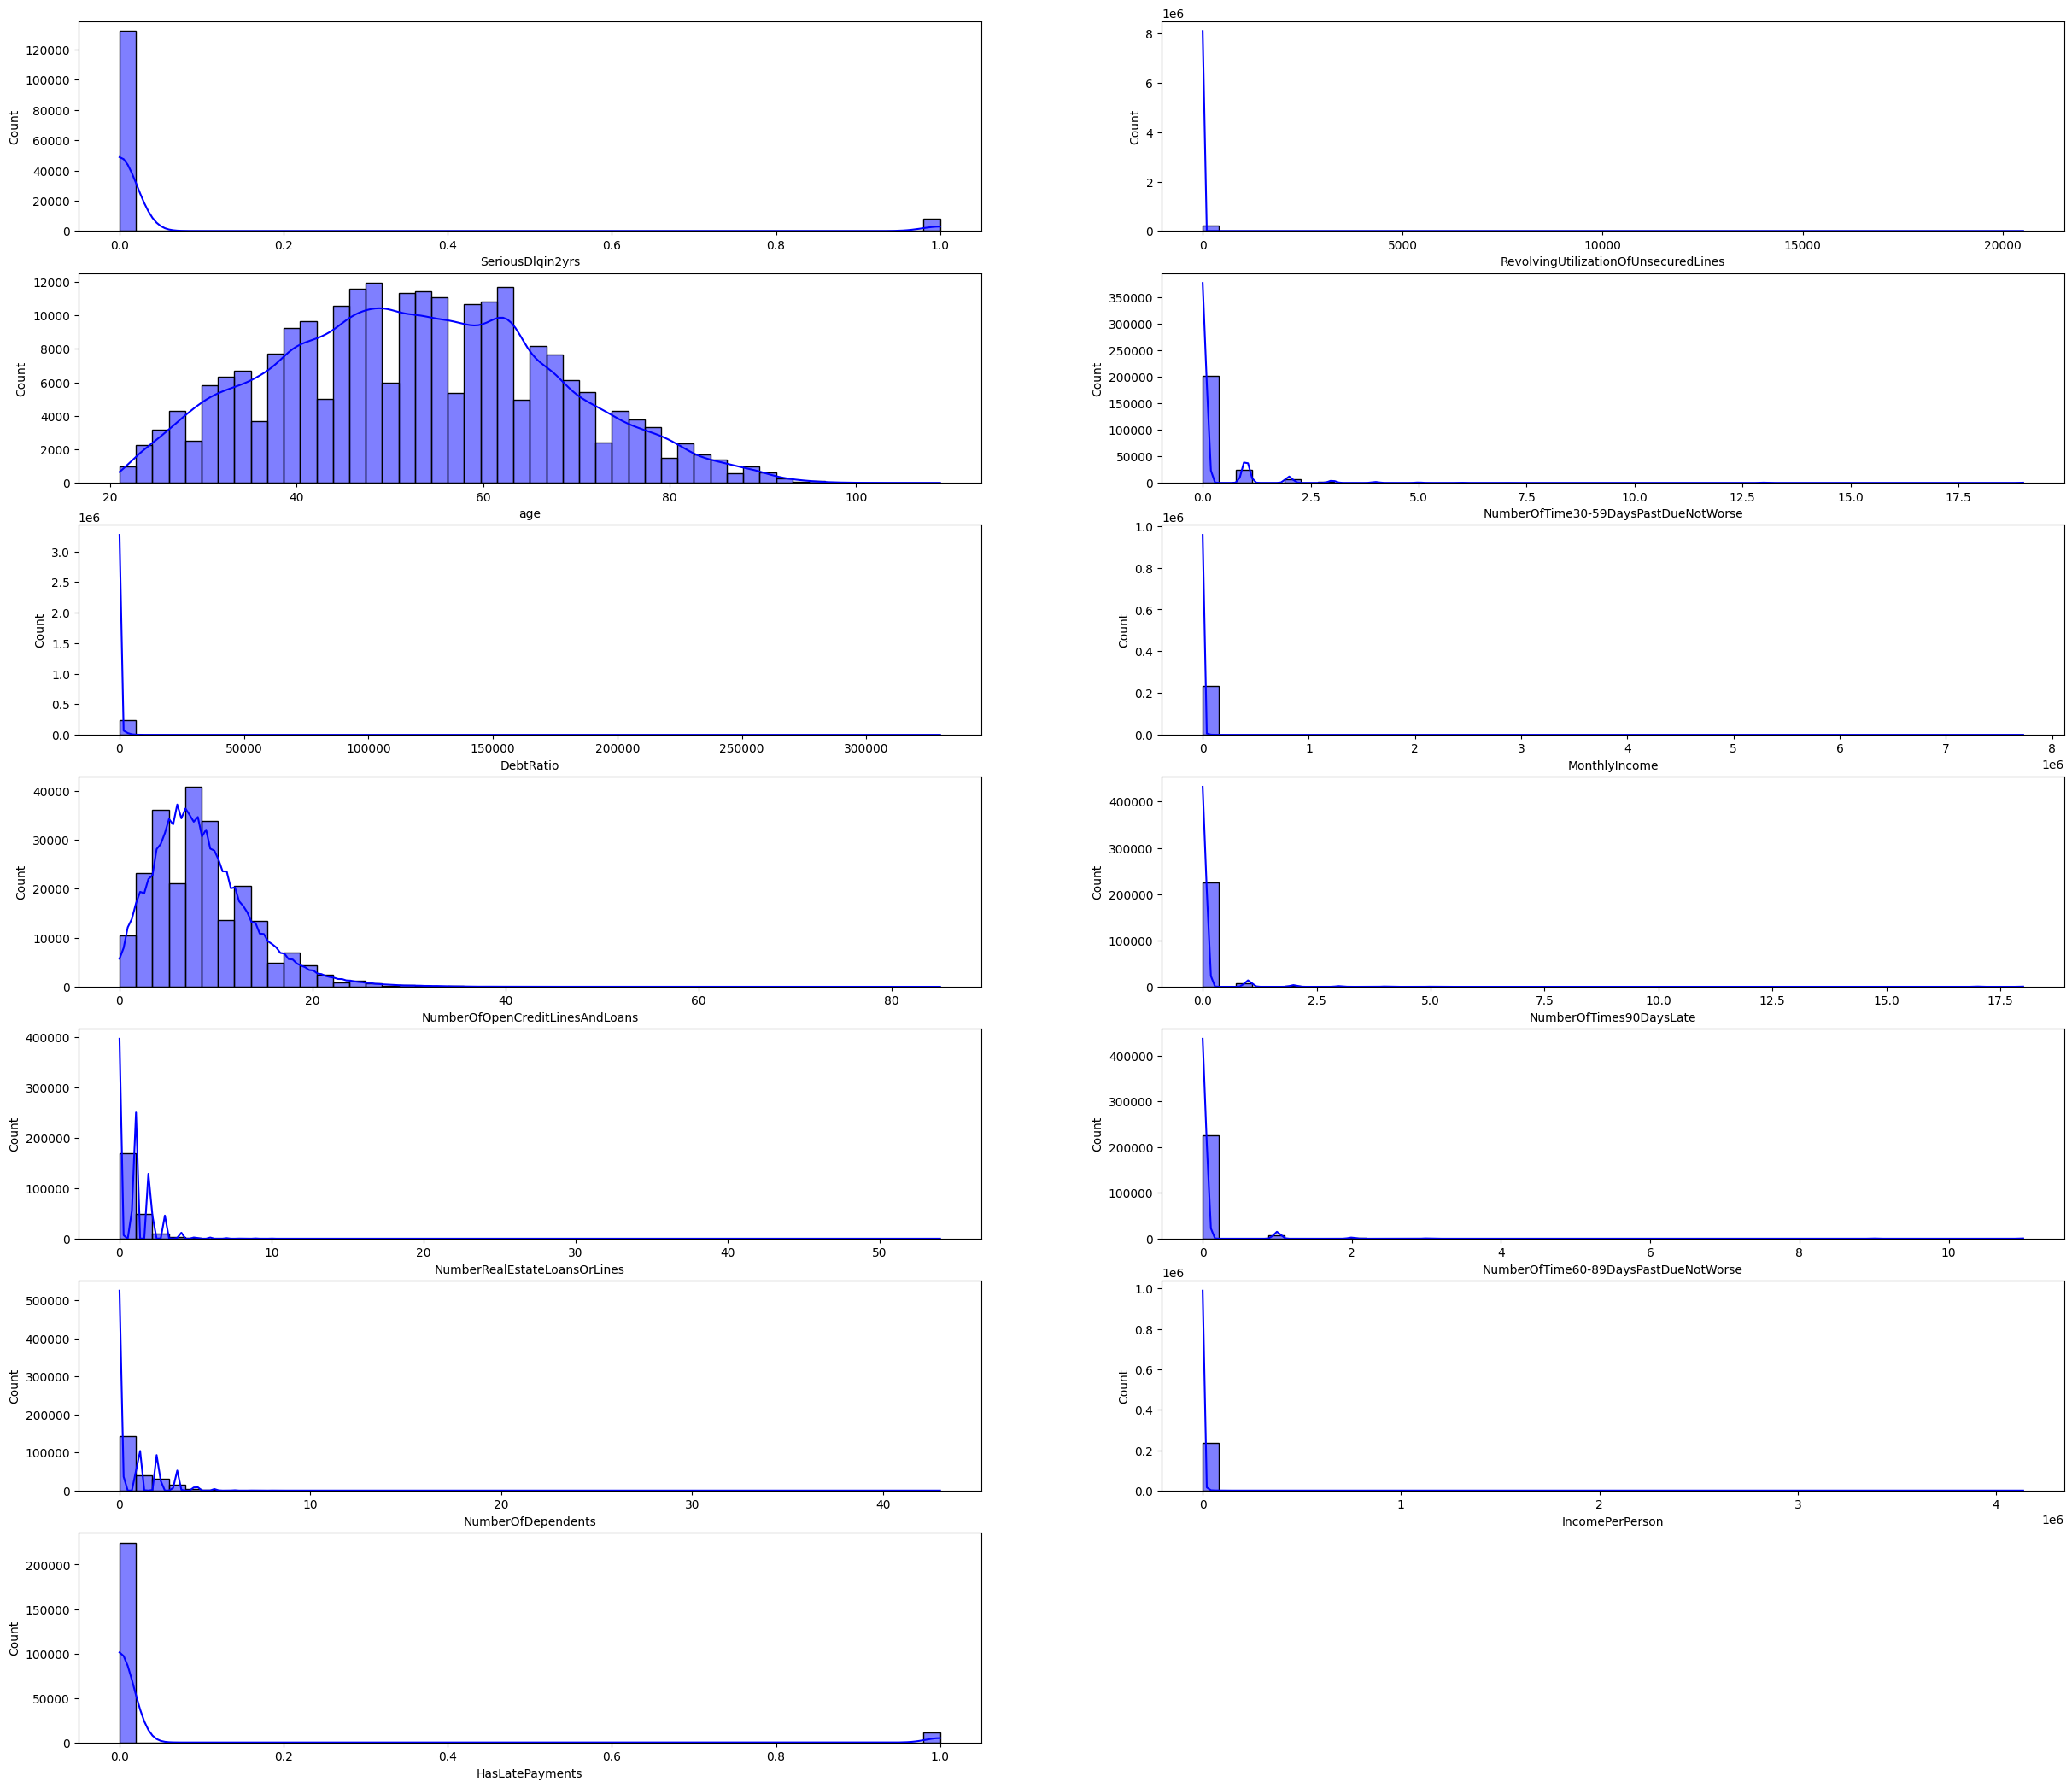

In [29]:
# Feature distribution of the cleaned dataset
fig = plt.figure(figsize=(30, 30))
for i, feature in enumerate(analyze_data.columns):
    axes = fig.add_subplot(8, 2, i+1)
    sns.histplot(analyze_data[feature], kde=True, ax=axes, bins=50, color='blue')

We can see that most features have very high skewness, only 'age' have an almost symetric distribution.

In [30]:
# Skewness of the features
skewness = analyze_data.skew()
skewness

SeriousDlqin2yrs                          3.836926
RevolvingUtilizationOfUnsecuredLines    246.787478
age                                       0.166955
NumberOfTime30-59DaysPastDueNotWorse     10.737714
DebtRatio                                93.046471
MonthlyIncome                           212.790400
NumberOfOpenCreditLinesAndLoans           1.178414
NumberOfTimes90DaysLate                  16.371640
NumberRealEstateLoansOrLines              3.246002
NumberOfTime60-89DaysPastDueNotWorse     14.854834
NumberOfDependents                        1.857428
IncomePerPerson                         201.349138
HasLatePayments                           4.312873
dtype: float64

Data transformation to reduce skewness of features to prevent model distortion :
<br>
- Each feature is right skewed (skewness > 0)
- We will use different transformation technics regarding how strongly skewed our features are
- No need transformation for binary feature (HasLatePayments)
- 'age' is close to a normal distribution, we will use StandardScaler to transform

In [31]:
# Reduce extremely highly skewed features (>90) using log transformation (log(1 + x) to handle zero values safely)
for col in ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome', 'IncomePerPerson']:
    analyze_data[col] = np.log1p(analyze_data[col])

# Reduce skewness for highly skewed features (>10) using cube root transformation
for col in ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse']:
    analyze_data[col] = np.cbrt(analyze_data[col])

# Reduce skewness for moderately skewed features (>1) using square root transformation
for col in ['NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines', 'NumberOfDependents']:
    analyze_data[col] = np.sqrt(analyze_data[col])

# Age transformation using StandardScaler
scaler = StandardScaler()
analyze_data['age'] = scaler.fit_transform(analyze_data[['age']])

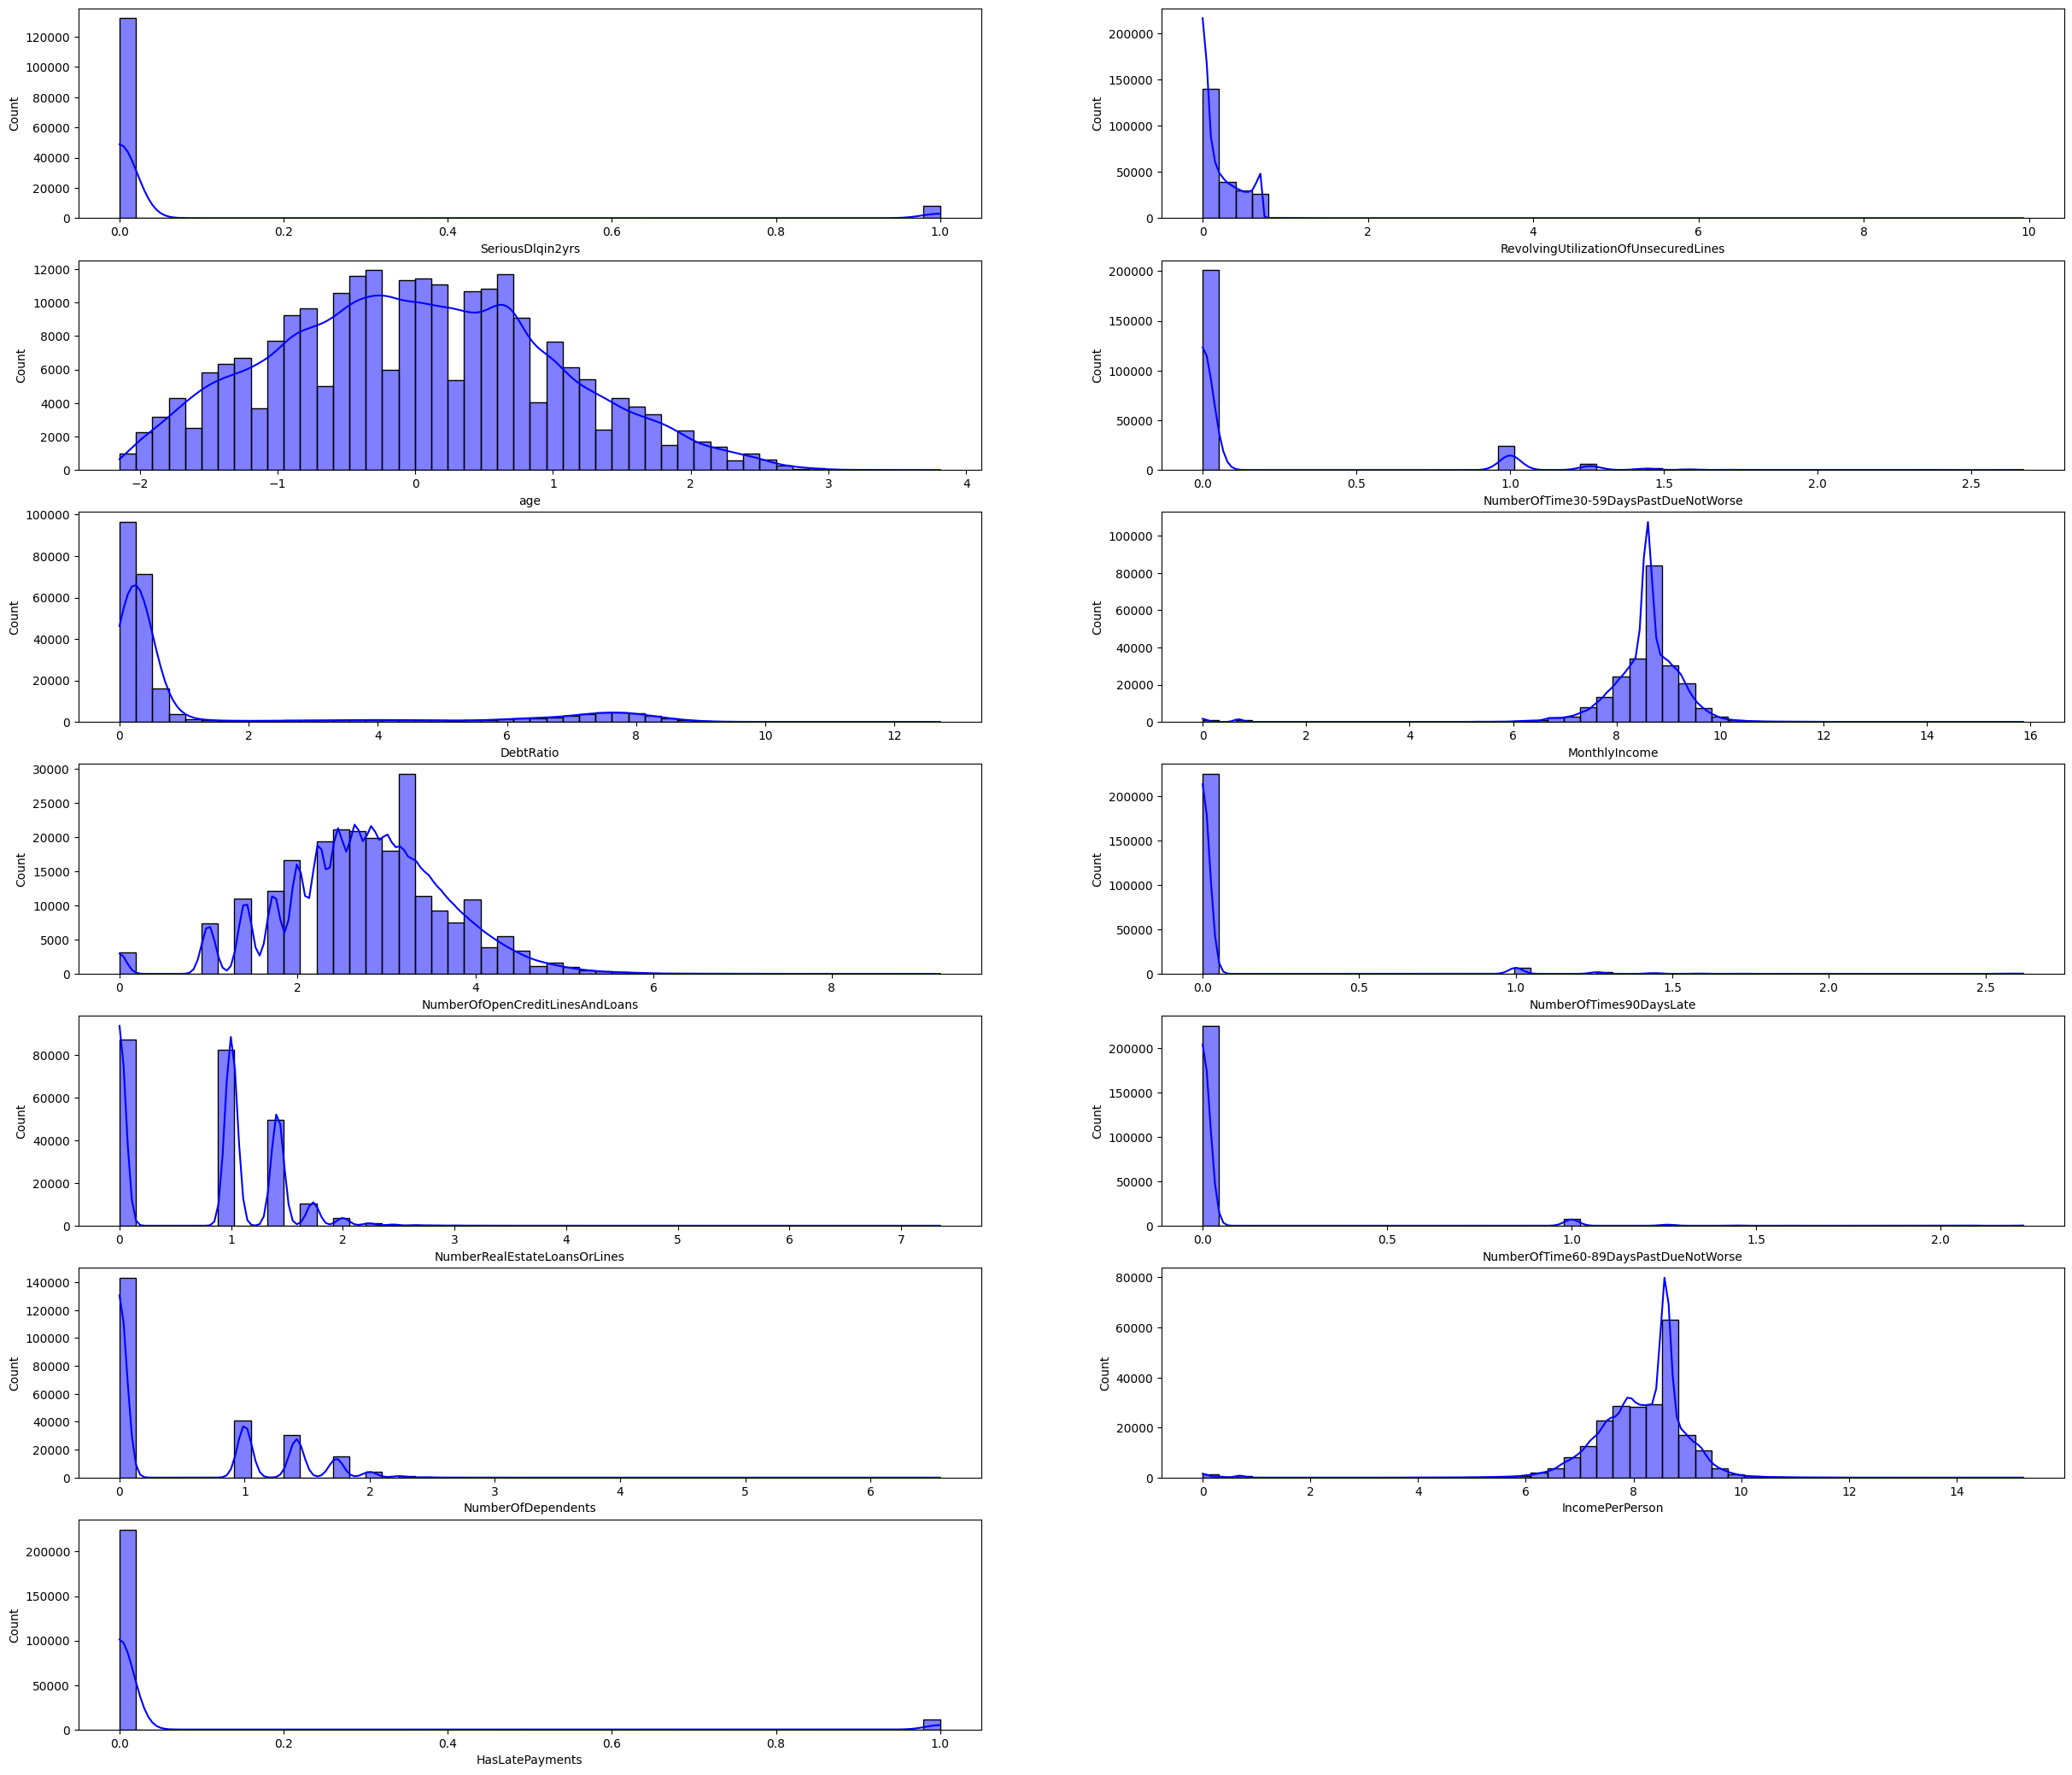

In [32]:
# Feature distribution after data transformation
fig = plt.figure(figsize=(30, 30))
for i, feature in enumerate(analyze_data.columns):
    axes = fig.add_subplot(8, 2, i+1)
    sns.histplot(analyze_data[feature], kde=True, ax=axes, bins=50, color='blue')

In [33]:
# Skewness of the features
skewness = analyze_data.skew()
skewness

SeriousDlqin2yrs                        3.836926
RevolvingUtilizationOfUnsecuredLines    4.977513
age                                     0.166955
NumberOfTime30-59DaysPastDueNotWorse    2.305026
DebtRatio                               1.791385
MonthlyIncome                          -4.984135
NumberOfOpenCreditLinesAndLoans        -0.092533
NumberOfTimes90DaysLate                 5.256866
NumberRealEstateLoansOrLines            0.048672
NumberOfTime60-89DaysPastDueNotWorse    5.139865
NumberOfDependents                      0.764774
IncomePerPerson                        -3.846158
HasLatePayments                         4.312873
dtype: float64

## Feature Selection

Text(0.5, 1.0, 'Feature Correlation Heatmap')

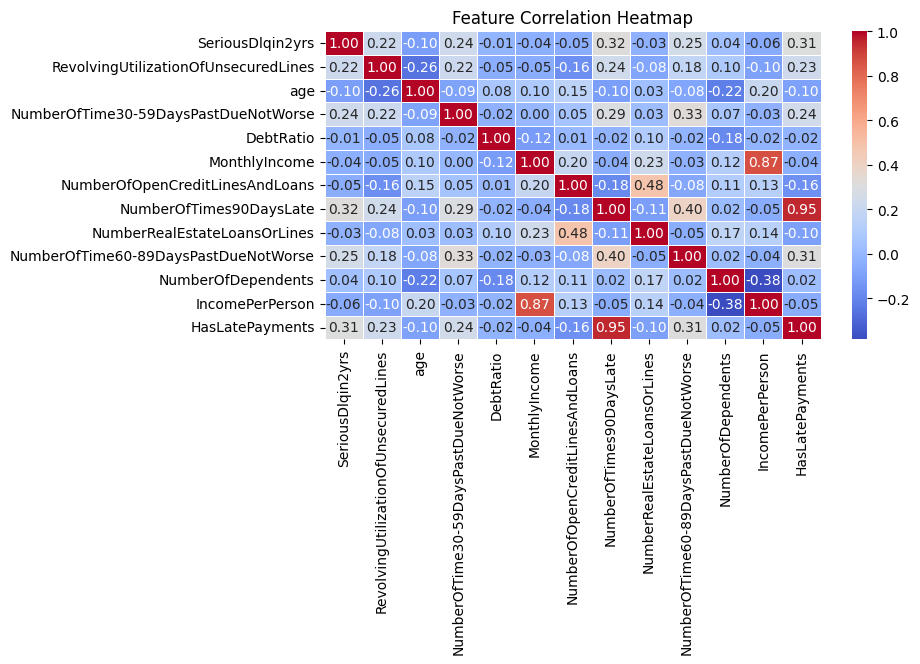

In [34]:
# Feature correlation heatmap of the cleaned dataset
plt.figure(figsize=(8, 4))
corr_matrix = analyze_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')

Regarding the correlation matrix, we can start by eliminating features that present redundancy in our data (correlation > 0.8) and model overfitting:
- 'HasLatePayments' and 'NumberOfTimes90DaysLate' are strongly correlated, we choose to keep 'HasLatePayments' as it is a binary variable wich makes it more interpretable.
- 'IncomePerPerson' and 'MonthlyIncome' are also strongly correlated (0.79 almost equal to 0.8), we choose to keep 'IncomePerPerson' as it takes in account number of dependents (family size) which is more informative.

In [35]:
# Drop columns with high correlation
analyze_data.drop(columns=['MonthlyIncome', 'NumberOfTimes90DaysLate'], inplace=True)

Now that we have analyzed the correlation matrix (linear correlation between our features), we use Mutual Information to measure how much information a feature provides about the target (SeriousDlqin2yrs). This allows us to catch non-linear relationships.

In [36]:
# Get our training datas and testing datas in different dataset back
final_train_data = analyze_data[:len(final_train_data)]
final_test_data = analyze_data[len(final_train_data):]

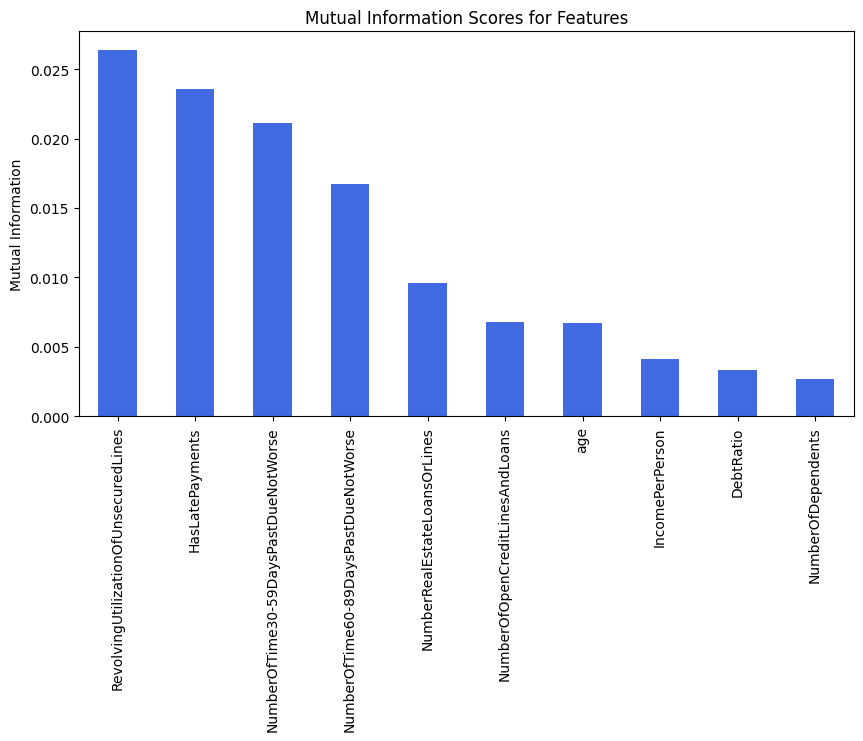

In [37]:
# We use Mutual Information on train dataset as testing dataset does not have values for target column
X = final_train_data.drop(columns=['SeriousDlqin2yrs'])     # Features
y = final_train_data['SeriousDlqin2yrs']                    # Target

mi_scores = mutual_info_classif(X, y, discrete_features=False)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Plot MI Scores
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
mi_scores.plot(kind="bar", color='royalblue')
plt.title("Mutual Information Scores for Features")
plt.ylabel("Mutual Information")
plt.show()

Regarding the results, we consider that each feature carries enough information for us to keep them.

# Model Implementation


Tuning hyperparameters for Logistic Regression...


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-pack


Logistic Regression Performance:
              precision    recall  f1-score   support

         0.0       0.98      0.80      0.88     39639
         1.0       0.18      0.73      0.29      2379

    accuracy                           0.79     42018
   macro avg       0.58      0.76      0.58     42018
weighted avg       0.93      0.79      0.85     42018


Best Parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}
Accuracy: 0.7928982816888
F1 Score: 0.286253280839895
AUC-ROC: 0.8427231627141553

Tuning hyperparameters for Random Forest...

Random Forest Performance:
              precision    recall  f1-score   support

         0.0       0.98      0.82      0.89     39639
         1.0       0.19      0.71      0.30      2379

    accuracy                           0.82     42018
   macro avg       0.59      0.77      0.60     42018
weighted avg       0.93      0.82      0.86     42018


Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_de

C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [23:22:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Performance:
              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87     39639
         1.0       0.18      0.78      0.29      2379

    accuracy                           0.78     42018
   macro avg       0.58      0.78      0.58     42018
weighted avg       0.94      0.78      0.84     42018


Best Parameters: {'subsample': 1.0, 'scale_pos_weight': 16.661502431994236, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Accuracy: 0.7817601980103766
F1 Score: 0.28704711553413154
AUC-ROC: 0.8525452825452949


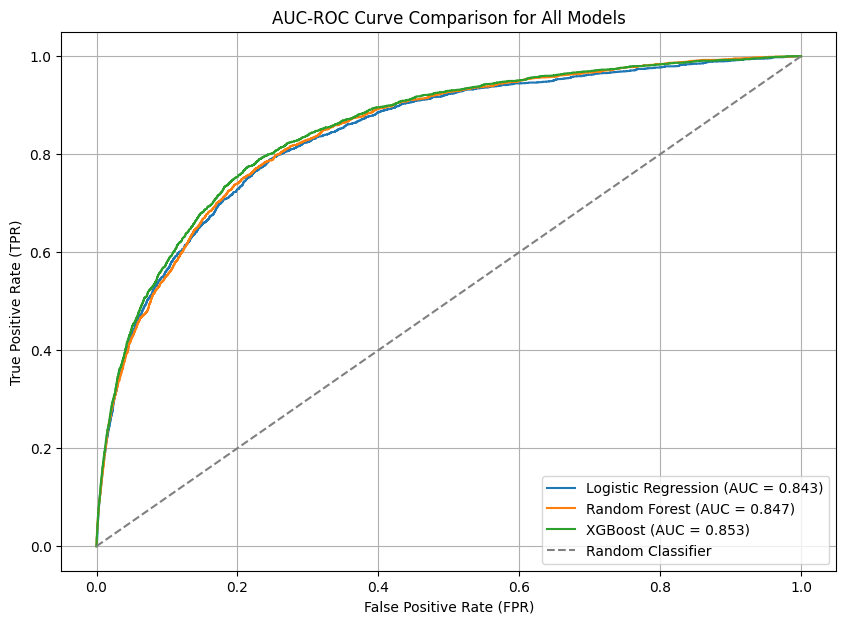


Model Performance Summary:


,Best Params,Accuracy,F1 Score,AUC-ROC
Logistic Regression,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}",0.792898,0.286253,0.842723
Random Forest,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.815603,0.303363,0.846591
XGBoost,"{'subsample': 1.0, 'scale_pos_weight': 16.6615...",0.78176,0.287047,0.852545


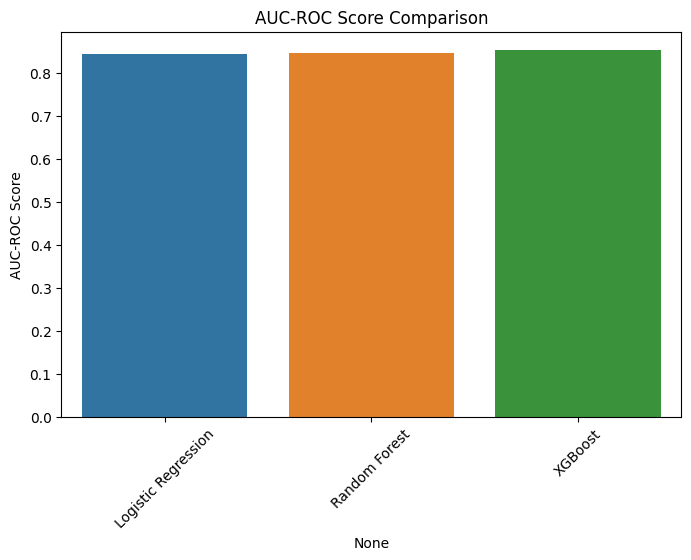


Best Performing Model: XGBoost

Best Hyperparameters: {'subsample': 1.0, 'scale_pos_weight': 16.661502431994236, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [38]:
# Splitting the data
X = final_train_data.drop(columns=['SeriousDlqin2yrs'])     # Features
y = final_train_data['SeriousDlqin2yrs']                    # Target

# Stratify the target variable to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define parameter grids for hyperparameter tuning
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],  
        'solver': ['liblinear', 'lbfgs'],  
        'penalty': ['l1', 'l2']
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],  
        'max_depth': [10, 20, None],  
        'min_samples_split': [2, 5, 10],  
        'min_samples_leaf': [1, 2, 5],  
        'class_weight': ['balanced']
    },
    'XGBoost': {
        'n_estimators': [100, 300, 500],  
        'max_depth': [3, 6, 10],  
        'learning_rate': [0.01, 0.1, 0.125, 0.2],  
        'subsample': [0.6, 0.8, 1.0],  
        'colsample_bytree': [0.6, 0.8, 1.0],  
        'scale_pos_weight': [len(y_train[y_train == 0]) / len(y_train[y_train == 1])]
    }
}

# Define models
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
}

# Plot AUC-ROC Curves for Each Model
plt.figure(figsize=(10, 7))

# Train & Evaluate Models
results = {}
for name, model in models.items():
    print(f"\nTuning hyperparameters for {name}...")
    
    random_search = RandomizedSearchCV(
        model,
        param_grids[name],
        scoring='roc_auc',
        cv=5,
        random_state=42,
        n_jobs=-1
    )
    
    random_search.fit(X_train, y_train)
    
    # Best Model & Predictions
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # For AUC-ROC
    
    # Store Results
    results[name] = {
        'Best Params': random_search.best_params_,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_prob)
    }
    
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))
    print(f"\nBest Parameters: {random_search.best_params_}")
    print(f"Accuracy: {results[name]['Accuracy']}")
    print(f"F1 Score: {results[name]['F1 Score']}")
    print(f"AUC-ROC: {results[name]['AUC-ROC']}")

    # Compute ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot Each Model's ROC Curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

# Plot Random Classifier Baseline
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')

# Formatting the ROC Curve Plot
plt.title("AUC-ROC Curve Comparison for All Models")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

results_df = pd.DataFrame(results).T
print("\nModel Performance Summary:")
display(results_df)

# Plot AUC-ROC Scores
plt.figure(figsize=(8, 5))
sns.barplot(x=results_df.index, y=results_df['AUC-ROC'], hue=results_df.index, legend=False)
plt.title("AUC-ROC Score Comparison")
plt.ylabel("AUC-ROC Score")
plt.xticks(rotation=45)
plt.show()

# Best Model Selection
best_model_name = results_df['AUC-ROC'].idxmax()
best_model_params = results[best_model_name]['Best Params']

print(f"\nBest Performing Model: {best_model_name}")
print(f"\nBest Hyperparameters: {best_model_params}")

In [44]:
results

{'Logistic Regression': {'Best Params': {'solver': 'lbfgs',
   'penalty': 'l2',
   'C': 1},
  'Accuracy': 0.7928982816888,
  'F1 Score': 0.286253280839895,
  'AUC-ROC': 0.8427231627141553},
 'Random Forest': {'Best Params': {'n_estimators': 200,
   'min_samples_split': 5,
   'min_samples_leaf': 5,
   'max_depth': 10,
   'class_weight': 'balanced'},
  'Accuracy': 0.8156028368794326,
  'F1 Score': 0.30336270454954145,
  'AUC-ROC': 0.8465906752535791},
 'XGBoost': {'Best Params': {'subsample': 1.0,
   'scale_pos_weight': 16.661502431994236,
   'n_estimators': 100,
   'max_depth': 3,
   'learning_rate': 0.1,
   'colsample_bytree': 0.8},
  'Accuracy': 0.7817601980103766,
  'F1 Score': 0.28704711553413154,
  'AUC-ROC': 0.8525452825452949}}

Here we can see that our XGBoost Model has the best performance. 
<br>Now we are going to try with a Neural Network approach.

In [39]:
# Compute Class Weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader for Batches
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define F1 Loss Function to handle class imbalance
class F1Loss(nn.Module):
    def __init__(self, epsilon=1e-7):
        super(F1Loss, self).__init__()
        self.epsilon = epsilon

    def forward(self, y_pred, y_true):
        y_pred = torch.sigmoid(y_pred)
        y_pred = torch.round(y_pred)
        
        tp = (y_true * y_pred).sum().to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
        
        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)
        
        f1 = 2 * (precision * recall) / (precision + recall + self.epsilon)
        return 1 - f1                                                           # To minimize loss we return: 1 - F1 Score

# Define Neural Network Model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize Model, Loss, Optimizer
model = NeuralNetwork(input_size=X_train.shape[1])
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # Apply class weight and includes sigmoid
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train Model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")

# Evaluate Model
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).squeeze()
    y_test_pred = torch.sigmoid(y_test_pred)
    y_test_pred = (y_test_pred > 0.5).float()

# Convert Predictions to NumPy
y_test_np = y_test_tensor.numpy()
y_pred_np = y_test_pred.numpy()

print("\nNeural Network Performance:")
print(classification_report(y_test_np, y_pred_np))
print(f"Accuracy: {accuracy_score(y_test_np, y_pred_np):.4f}")
print(f"F1 Score: {f1_score(y_test_np, y_pred_np):.4f}")
print(f"AUC-ROC Score: {roc_auc_score(y_test_np, y_pred_np):.4f}")

Epoch 1/50, Loss: 0.6904
Epoch 2/50, Loss: 0.6601
Epoch 3/50, Loss: 0.6547
Epoch 4/50, Loss: 0.6513
Epoch 5/50, Loss: 0.6508
Epoch 6/50, Loss: 0.6484
Epoch 7/50, Loss: 0.6460
Epoch 8/50, Loss: 0.6448
Epoch 9/50, Loss: 0.6450
Epoch 10/50, Loss: 0.6436
Epoch 11/50, Loss: 0.6418
Epoch 12/50, Loss: 0.6429
Epoch 13/50, Loss: 0.6422
Epoch 14/50, Loss: 0.6411
Epoch 15/50, Loss: 0.6404
Epoch 16/50, Loss: 0.6402
Epoch 17/50, Loss: 0.6400
Epoch 18/50, Loss: 0.6386
Epoch 19/50, Loss: 0.6393
Epoch 20/50, Loss: 0.6385
Epoch 21/50, Loss: 0.6386
Epoch 22/50, Loss: 0.6364
Epoch 23/50, Loss: 0.6363
Epoch 24/50, Loss: 0.6360
Epoch 25/50, Loss: 0.6361
Epoch 26/50, Loss: 0.6355
Epoch 27/50, Loss: 0.6350
Epoch 28/50, Loss: 0.6346
Epoch 29/50, Loss: 0.6337
Epoch 30/50, Loss: 0.6337
Epoch 31/50, Loss: 0.6343
Epoch 32/50, Loss: 0.6332
Epoch 33/50, Loss: 0.6319
Epoch 34/50, Loss: 0.6320
Epoch 35/50, Loss: 0.6315
Epoch 36/50, Loss: 0.6313
Epoch 37/50, Loss: 0.6307
Epoch 38/50, Loss: 0.6309
Epoch 39/50, Loss: 0.

The Neural Network shows slightly better results on the AUC-ROC score and F1 score.
<br>Thus, we'll consider it as the best model to use for this solution.

We will now use SHAP for model prediction explaination to showcase which feature has more impact on model classification.

100%|===================| 42007/42018 [00:40<00:00]        C:\Users\mathi\AppData\Local\Temp\ipykernel_10856\1095753358.py:16: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


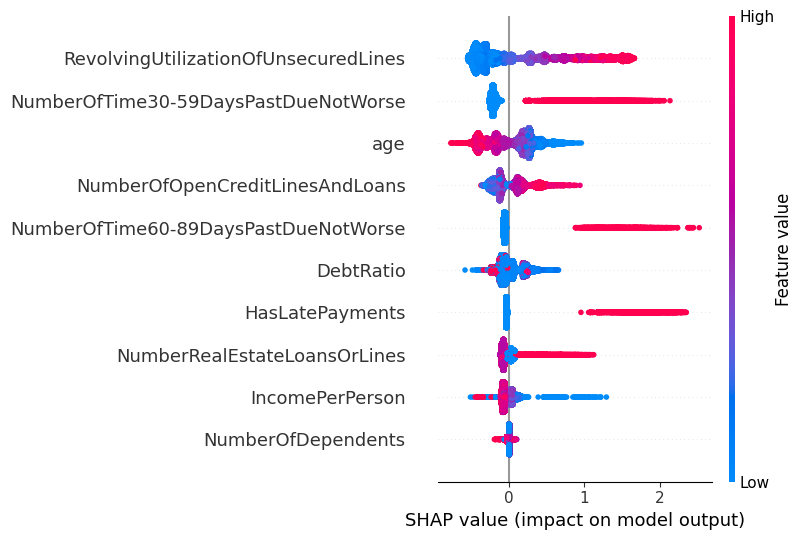

In [51]:
# Retrieve Best Parameters from Hyperparameter Tuning
best_xgb_params = results['XGBoost']['Best Params']

# Rebuild and Train the XGBoost Model
best_xgb = XGBClassifier(**best_xgb_params, eval_metric='logloss')
best_xgb.fit(X_train, y_train)

# Initialize SHAP Explainer
explainer = shap.Explainer(best_xgb, X_test, algorithm="auto")

# Compute SHAP Values
shap_values = explainer(X_test)

# Summary Plot - Feature Importance
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test)